In [1]:
import pandas as pd
from datetime import datetime
import pm4py
import numpy as np
from collections import defaultdict
from Levenshtein import distance

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

import copy

In [2]:
log = pm4py.read.read_xes("BPIC15GroundTruth.xes")

C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 5649/5649 [00:22<00:00, 245.68it/s]


In [3]:
log

,org:resource,concept:name,lifecycle:transition,time:timestamp,case:creator,case:concept:name,case:variant,case:variant-index,case:cluster:label,(case)_SUMleges,...,(case)_parts,question,(case)_termName,monitoringResource,(case)_case_type,(case)_IDofConceptCase,(case)_landRegisterID,(case)_caseProcedure,(case)_Includes_subCases,dateStop
0,artificial,ArtificialStartTask,complete,2014-04-10 21:59:59.999000+00:00,Fluxicon Disco,10009138,Variant 16,16,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,9264148,01_HOOFD,complete,2014-04-10 22:00:00+00:00,Fluxicon Disco,10009138,Variant 16,16,1,157.09305,...,"Bouw,Reclame",EMPTY,Termijn bezwaar en beroep 1,2670601,557669,10009280,NaN,NaN,NaN,NaT
2,9264148,02_DRZ,complete,2014-04-13 22:00:00+00:00,Fluxicon Disco,10009138,Variant 16,16,1,157.09305,...,"Bouw,Reclame",False,Termijn bezwaar en beroep 1,2670601,557669,10009280,NaN,NaN,NaN,NaT
3,9264148,04_BPT,complete,2014-04-13 22:00:00+00:00,Fluxicon Disco,10009138,Variant 16,16,1,157.09305,...,"Bouw,Reclame",True,Termijn bezwaar en beroep 1,2670601,557669,10009280,NaN,NaN,NaN,NaT
4,9264148,01_HOOFD,complete,2014-04-13 22:00:00+00:00,Fluxicon Disco,10009138,Variant 16,16,1,157.09305,...,"Bouw,Reclame",False,Termijn bezwaar en beroep 1,2670601,557669,10009280,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92421,560602,01_HOOFD,complete,2014-01-26 23:00:00+00:00,Fluxicon Disco,9998898,Variant 1153,1153,5,718.4468,...,"Bouw,Handelen in strijd met regels RO",True,NaN,560600,557669,9999524,10000071,NaN,NaN,NaT
92422,560600,01_BB,complete,2014-03-11 23:00:00+00:00,Fluxicon Disco,9998898,Variant 1153,1153,5,718.4468,...,"Bouw,Handelen in strijd met regels RO",False,NaN,560600,557669,9999524,10000071,NaN,NaN,NaT
92423,560600,01_HOOFD,complete,2014-03-11 23:00:00+00:00,Fluxicon Disco,9998898,Variant 1153,1153,5,718.4468,...,"Bouw,Handelen in strijd met regels RO",EMPTY,NaN,560600,557669,9999524,10000071,NaN,NaN,NaT
92424,560600,01_BB,complete,2014-03-11 23:00:00+00:00,Fluxicon Disco,9998898,Variant 1153,1153,5,718.4468,...,"Bouw,Handelen in strijd met regels RO",EMPTY,NaN,560600,557669,9999524,10000071,NaN,NaN,NaT


In [4]:
log.nunique()

org:resource                   72
concept:name                   29
lifecycle:transition            1
time:timestamp              38194
case:creator                    1
case:concept:name            5647
case:variant                 1349
case:variant-index           1349
case:cluster:label              5
(case)_SUMleges              2445
dateFinished                13365
dueDate                      7085
action_code                   389
activityNameEN                293
planned                     54942
(case)_caseStatus               3
(case)_Responsible_actor       63
activityNameNL                293
(case)_last_phase              42
(case)_requestComplete          2
(case)_parts                  209
question                      646
(case)_termName                20
monitoringResource             77
(case)_case_type                1
(case)_IDofConceptCase       3182
(case)_landRegisterID        1490
(case)_caseProcedure            2
(case)_Includes_subCases        2
dateStop      

In [6]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'tabName_element' column
log['activity'] = le.fit_transform(log['concept:name'])

log_select = log[['case:concept:name', 'time:timestamp', 'activity', 'case:cluster:label']]
log_select

,case:concept:name,time:timestamp,activity,case:cluster:label
0,10009138,2014-04-10 21:59:59.999000+00:00,28,1
1,10009138,2014-04-10 22:00:00+00:00,1,1
2,10009138,2014-04-13 22:00:00+00:00,3,1
3,10009138,2014-04-13 22:00:00+00:00,7,1
4,10009138,2014-04-13 22:00:00+00:00,1,1
...,...,...,...,...
92421,9998898,2014-01-26 23:00:00+00:00,1,5
92422,9998898,2014-03-11 23:00:00+00:00,0,5
92423,9998898,2014-03-11 23:00:00+00:00,1,5
92424,9998898,2014-03-11 23:00:00+00:00,0,5


In [7]:
log_select2 = log_select.sort_values(by='time:timestamp',ascending=False)
log_select_new = log_select2.drop_duplicates(subset=['case:concept:name'])
log_select_new = log_select_new.sort_values(by='case:concept:name',ascending=True)
trueList = list(log_select_new["case:cluster:label"])

#print(log_select_new["case:concept:name"], logVar["case:concept:name"])
#print(len(log_select_new), len(logVar))

In [8]:
#Create trace log

logVar = log_select2.groupby(['case:concept:name'])['activity'].apply(list).reset_index()
logVar

#2 cases are missing??
#Issue of identical time stamps!!

,case:concept:name,activity
0,10002357,"[27, 0, 0, 1, 18, 1, 12, 1, 21, 1, 14, 7, 1, 3..."
1,10003250,"[27, 3, 7, 1, 1, 28]"
2,10009138,"[27, 1, 12, 1, 14, 1, 18, 21, 1, 7, 3, 1, 28]"
3,10044776,"[27, 1, 3, 7, 1, 28]"
4,10051383,"[27, 1, 1, 12, 14, 1, 21, 18, 1, 12, 1, 12, 1,..."
...,...,...
5642,9988302,"[27, 0, 0, 1, 0, 1, 24, 1, 1, 18, 1, 14, 7, 1,..."
5643,9989988,"[27, 1, 24, 14, 21, 1, 18, 1, 1, 12, 7, 1, 22,..."
5644,9990823,"[27, 24, 1, 1, 22, 1, 12, 21, 18, 1, 1, 14, 5,..."
5645,9996445,"[27, 18, 1, 12, 1, 14, 1, 21, 1, 12, 1, 12, 1,..."


In [9]:
#import ast

#logVar["activity"] = logVar["activity"].apply(lambda x: ast.literal_eval(x))
logVar["c:n_chr"] = logVar["activity"].apply(lambda x: [chr(int(i)) for i in x])
logVar["strings"] = logVar["c:n_chr"].apply(lambda x: ''.join(x))
logVar

,case:concept:name,activity,c:n_chr,strings
0,10002357,"[27, 0, 0, 1, 18, 1, 12, 1, 21, 1, 14, 7, 1, 3...","[,  ,  , , , , , , , , , , , , , ...",   
1,10003250,"[27, 3, 7, 1, 1, 28]","[, , , , , ]",
2,10009138,"[27, 1, 12, 1, 14, 1, 18, 21, 1, 7, 3, 1, 28]","[, , , , , , , , , , , , ]", 
3,10044776,"[27, 1, 3, 7, 1, 28]","[, , , , , ]",
4,10051383,"[27, 1, 1, 12, 14, 1, 21, 18, 1, 12, 1, 12, 1,...","[, , , , , , , , , , , , , , , ...",    
...,...,...,...,...
5642,9988302,"[27, 0, 0, 1, 0, 1, 24, 1, 1, 18, 1, 14, 7, 1,...","[,  ,  , ,  , , , , , , , , , , , ...",    
5643,9989988,"[27, 1, 24, 14, 21, 1, 18, 1, 1, 12, 7, 1, 22,...","[, , , , , , , , , , , , , , , ...", 
5644,9990823,"[27, 24, 1, 1, 22, 1, 12, 21, 18, 1, 1, 14, 5,...","[, , , , , , , , , , , , , , , ...", 
5645,9996445,"[27, 18, 1, 12, 1, 14, 1, 21, 1, 12, 1, 12, 1,...","[, , , , , , , , , , , , , , , ...",     


In [10]:
#Derive set set of trace variants

logVar = logVar.drop_duplicates(subset=['strings'], keep='first')
logVar = logVar.reset_index(drop=True)
logVar

,case:concept:name,activity,c:n_chr,strings
0,10002357,"[27, 0, 0, 1, 18, 1, 12, 1, 21, 1, 14, 7, 1, 3...","[,  ,  , , , , , , , , , , , , , ...",   
1,10003250,"[27, 3, 7, 1, 1, 28]","[, , , , , ]",
2,10009138,"[27, 1, 12, 1, 14, 1, 18, 21, 1, 7, 3, 1, 28]","[, , , , , , , , , , , , ]", 
3,10044776,"[27, 1, 3, 7, 1, 28]","[, , , , , ]",
4,10051383,"[27, 1, 1, 12, 14, 1, 21, 18, 1, 12, 1, 12, 1,...","[, , , , , , , , , , , , , , , ...",    
...,...,...,...,...
4204,9988302,"[27, 0, 0, 1, 0, 1, 24, 1, 1, 18, 1, 14, 7, 1,...","[,  ,  , ,  , , , , , , , , , , , ...",    
4205,9989988,"[27, 1, 24, 14, 21, 1, 18, 1, 1, 12, 7, 1, 22,...","[, , , , , , , , , , , , , , , ...", 
4206,9990823,"[27, 24, 1, 1, 22, 1, 12, 21, 18, 1, 1, 14, 5,...","[, , , , , , , , , , , , , , , ...", 
4207,9996445,"[27, 18, 1, 12, 1, 14, 1, 21, 1, 12, 1, 12, 1,...","[, , , , , , , , , , , , , , , ...",     


In [11]:
# Number of activity types
act = list(set([a for b in logVar.activity.tolist() for a in b]))
len(act)

29

In [12]:
#min, max length of traces
logVar["length"] = logVar["activity"].apply(lambda x: len(x))
print(logVar.length.min(), logVar.length.max())

3 76


In [13]:
logVar

,case:concept:name,activity,c:n_chr,strings,length
0,10002357,"[27, 0, 0, 1, 18, 1, 12, 1, 21, 1, 14, 7, 1, 3...","[,  ,  , , , , , , , , , , , , , ...",   ,17
1,10003250,"[27, 3, 7, 1, 1, 28]","[, , , , , ]",,6
2,10009138,"[27, 1, 12, 1, 14, 1, 18, 21, 1, 7, 3, 1, 28]","[, , , , , , , , , , , , ]", ,13
3,10044776,"[27, 1, 3, 7, 1, 28]","[, , , , , ]",,6
4,10051383,"[27, 1, 1, 12, 14, 1, 21, 18, 1, 12, 1, 12, 1,...","[, , , , , , , , , , , , , , , ...",    ,19
...,...,...,...,...,...
4204,9988302,"[27, 0, 0, 1, 0, 1, 24, 1, 1, 18, 1, 14, 7, 1,...","[,  ,  , ,  , , , , , , , , , , , ...",    ,25
4205,9989988,"[27, 1, 24, 14, 21, 1, 18, 1, 1, 12, 7, 1, 22,...","[, , , , , , , , , , , , , , , ...", ,20
4206,9990823,"[27, 24, 1, 1, 22, 1, 12, 21, 18, 1, 1, 14, 5,...","[, , , , , , , , , , , , , , , ...", ,20
4207,9996445,"[27, 18, 1, 12, 1, 14, 1, 21, 1, 12, 1, 12, 1,...","[, , , , , , , , , , , , , , , ...",     ,21


## Derive Variety Values

In [14]:
#Calculate Levenshtein Distance
from Levenshtein import distance

#Calculate linkage Matrix
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

#Distances after clustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import squareform

#For Evaluation
from scipy.integrate import simpson
from numpy import trapz
import scipy.stats

In [15]:
#Calculate overall Variety based on Minimum Spanning Tree
def mst(linkage_matrix):
    x = 0
    for i in linkage_matrix:
        x += i[2]
    return x

#logVariety = mst(linkage_matrix)
#logVariety

In [16]:
#Derive ordering of traces based on their marginal distance

def marginal_variety(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(len(pairwise_distances)-1):
        # Find the minimum value and its indices
        min_val = np.nanmin(modified_distances)  # Use np.nanmin to ignore NaN values
        min_indices = np.argwhere(modified_distances == min_val)
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = min_indices[0][0], min_indices[0][0]
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)
        margVariety.append(min_val)
        
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
    #return modified_distances
    return traceOrder, margVariety #modified_distances


#order, margVar = marginal_variety(cophenet_matrix)
#margVar

In [17]:
#Create ordered list of Alignment costs

def marginal_alignments(pairwise_distances, order):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    modified_distances = abs(modified_distances)
    #traceOrder = []
    margAlignments = []
    
    removed = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate over ordered list of trace variants to be removed
    for i in order:
        #Add i to list of removed TraceVar
        removed.append(i)
        alignmentCost = 0
        
        #Change values in the column corresponding to i to NaN
        modified_distances[:, i] = np.nan
        
        #Iterate over list of removed trace variants to derive alignment costs
        for i in removed:
            
            # Find the minimum value and its indices
            min_val = np.nanmin(modified_distances[i])  # Use np.nanmin to ignore NaN values
            
            #Add value to alignment cost
            alignmentCost += min_val
 
        #Add alignment cost to list
        margAlignments.append(alignmentCost)
        
        
    #return modified_distances
    return margAlignments #modified_distances



#margAlignCosts = marginal_alignments(Matrix_Align, order)
#margAlignCosts

In [18]:
#Calculate increase in alignment costs
def alignIncrease(margAlignCosts):
    inAlign = [0]
    newAlign = 0
    for i in margAlignCosts:
        newAlign += i
        inAlign.append(newAlign)
    return inAlign

#alignCostIncrease = alignIncrease(margAlignCosts)

In [19]:
#Calculate decrease in variety
def varDecrease(var, margVar):
    deVar = [var]
    newVar = var
    for i in margVar:
        newVar -= i
        deVar.append(newVar)
    return deVar

#varietyDecrease = varDecrease(logVariety, margVar)

## Based on Levenshtein Distance

In [20]:
#Calculate distance matrix based on Levenshtein Distance
from Levenshtein import distance

def Lev(logVar):
    
    List = logVar["strings"]

    n = len(List)
    dist_matrix = np.zeros((n,n))    # initialize distance matrix to a square of zeros

    for i in range(n):
        for j in range(i, n):
            dist_matrix[i,j] = distance(List[i], List[j])
            dist_matrix[j,i] = dist_matrix[i,j]       # for the symmetric part, no computation

    return dist_matrix

In [21]:
lev_dis = Lev(logVar)
lev_dis

array([[ 0., 12.,  8., ..., 10., 12., 22.],
       [12.,  0.,  9., ..., 14., 17., 31.],
       [ 8.,  9.,  0., ..., 12., 10., 27.],
       ...,
       [10., 14., 12., ...,  0., 13., 22.],
       [12., 17., 10., ..., 13.,  0., 20.],
       [22., 31., 27., ..., 22., 20.,  0.]])

In [25]:
def varAlignCosts(Matrix_Align):
    
    #Calculate linkage Matrix
    linkage_matrix = linkage(Matrix_Align, "complete")
    #linkage_matrix

    #Calculate overall Variety based on Minimum Spanning Tree
    logVariety = mst(linkage_matrix)
    #print('Overall variety:', logVariety)

    #Distances after clustering
    cophenet_matrix = squareform(cophenet(linkage_matrix))

    #Derive ordering of traces based on their marginal distance
    order, margVar = marginal_variety(cophenet_matrix)
    #margVar

    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    #margAlignCosts

    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)
        
    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(cophenet_matrix)))
    y = varietyDecrease
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    #print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    #print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

    #Evaluate Clustering
    #from scipy.cluster.hierarchy import fcluster
    labels = fcluster(linkage_matrix, t=len(logVar)/2, criterion='maxclust')
    silhoutte = metrics.silhouette_score(abs(Matrix_Align), labels, metric="precomputed")
    print("silhouette_value", silhoutte)

C:\Users\la1949\AppData\Local\Temp\ipykernel_17480\469129244.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(Matrix_Align, "complete")


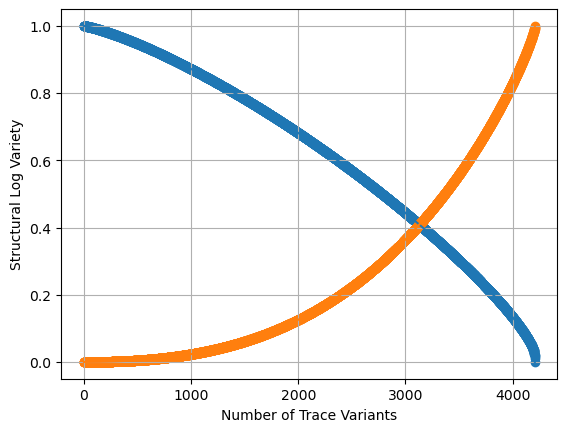

intersection: [3129]
area_trapeziodal: 1062.4411259438593
area_Simpson: 1062.4408045656214
Pearson's r: PearsonRResult(statistic=-0.9694560196247739, pvalue=0.0)
silhouette_value 0.0008536872555354488


In [26]:
varAlignCosts(lev_dis)

## Baseline

In [22]:
#Derive ordering of traces based on random selection
import math

def marginal_variety_baseline(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    totalVariety = []
    numbVar = len(pairwise_distances)
    remaining = list(range(0,numbVar))
    
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(numbVar-1):
        
        #Select random variant to be removed
        indices = np.random.choice(remaining)
        remaining.remove(indices)
        min_val = np.nanmin(modified_distances[indices])
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = indices, indices
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)        
        margVariety.append(min_val)
        
        #Calculate variety based on distances of remaining traces 
        variety = 0
        for i in modified_distances:
            if math.isnan(np.nanmin(i)):
                continue
            variety += np.nanmin(i)
        totalVariety.append(variety)
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
        
    #return modified_distances
    return traceOrder, margVariety, totalVariety #modified_distances

In [23]:
def varAlignCosts2(Matrix_Align):
    
    order, margVar, totalVar = marginal_variety_baseline(Matrix_Align)
    totalVar.append(0)
    
    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    
    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)
    
    
    #Calculate overall Variety based on sum of margVar
    logVariety = sum(margVar)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)


    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(Matrix_Align)))
    y = totalVar
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)
    
    #Monotonicity trend
    diffs = np.diff(totalVar)
    monoRate = np.sum(diffs >= 0) / (len(totalVar)-2)
    print("monotonViolation:", monoRate)
    print("equality:", np.sum(diffs == 0))
    print("increase:", np.sum(diffs > 0))


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

C:\Users\la1949\AppData\Local\Temp\ipykernel_13996\3781539750.py:36: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


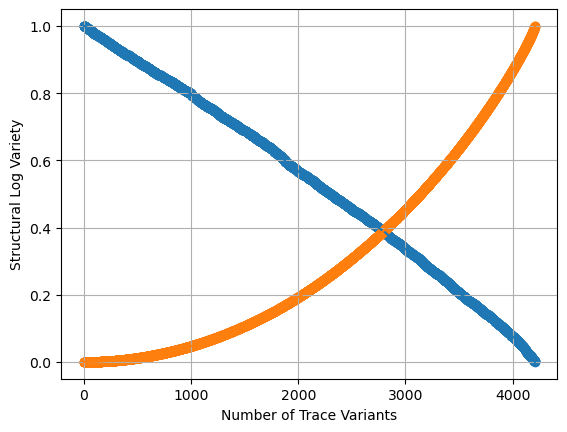

intersection: [2794]
area_trapeziodal: 1277.0478505532992
area_Simpson: 1277.04773326501
monotonViolation: 0.12241502258141193
equality: 313
increase: 202
Pearson's r: PearsonRResult(statistic=-0.9694615966260144, pvalue=0.0)
Spearman's rho: SignificanceResult(statistic=-0.9999999030380029, pvalue=0.0)
Kendall's tau: SignificanceResult(statistic=-0.9999092660100017, pvalue=0.0)


In [24]:
varAlignCosts2(lev_dis)